# ADMET PROPERTIES

First, we import the necessary modules:

In [1]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

And we get a CSV from the SDF original file

In [2]:
sdfdatabase = 'pharmit_output.sdf'
MoleculeDatabase = PandasTools.LoadSDF(sdfdatabase, embedProps=True, molColName=None, smilesName='smiles')

## The Rule of Five

We can calculate the Rule of Five properties (molecular weight, number of hydrogen bond acceptors and donors, and logP) using some of the descriptors available in rdkit. First. we define the function:

In [3]:
def calculate_ro5_properties(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) == 5 
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA", "ro5_fulfilled"],
    )

And then, we apply it:

In [4]:
# Calculate RO5 properties for all molecules
ro5_properties = MoleculeDatabase["smiles"].apply(calculate_ro5_properties)
#Mix the Ro5 dataframe with the read csv
MoleculeDatabase_Concat = pd.concat([MoleculeDatabase, ro5_properties], axis=1)
#And separate by valid and invalid drugs (~ negates boolean values)
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase_Concat[MoleculeDatabase_Concat["ro5_fulfilled"]]
MoleculeDatabase_ro5_violated = MoleculeDatabase_Concat[~MoleculeDatabase_Concat["ro5_fulfilled"]]
print(f"{len(MoleculeDatabase_ro5_fulfilled)} Ro5-following compounds found")

13 Ro5-following compounds found


## Visualize the Ro5 properties

To better understand how our compounds fall in the Ro5 (which we are using as a shortcut to predict ADME) scale, here we will calculate some statistical parameters, and represent them using a radar plot.

First, we will define a helper function to calculate the mean and standard deviation of an input DataFrame.

In [5]:
def calculate_mean_std(dataframe):
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

And then, we apply the function to both the the Ro5-following and the Ro5-violating compounds, specifying that we **dont** want to use the SMILES, ID, rmsd or ro5_fulfilled columns:

In [6]:
MolDB_ro5_true_stats = calculate_mean_std(MoleculeDatabase_ro5_fulfilled[["molecular_weight",
                                                                          "n_hba", "n_hbd", "logp", "TPSA"]])
MolDB_ro5_false_stats = calculate_mean_std(MoleculeDatabase_ro5_violated[["molecular_weight", "n_hba", 
                                                                          "n_hbd", "logp", "TPSA"]])

---

Now, we have to define the functions that will help us plot the data. Since the properties used for the Ro5 criteria are of different magnitudes (the MWT has a threshold of 500, the number of HBAs and HBDs and the LogP have thresholds of only 10, 5, and 5, respectively, and TPSA has a threshold of 140), we want to tranform all scales to a 1-to-5 scale, so that it their meaning can be better understood. We will use the following formula:

```scaled property value = property value / property threshold * scaled property threshold```

    scaled MWT = MWT / 500 * 5 = MWT / 100
    scaled HBA = HBA / 10 * 5 = HBA / 2
    scaled HBD = HBD / 5 * 5 = HBD
    scaled LogP = LogP / 5 * 5 = LogP
    scaled TPSA = TPSA/140 *5 = TPSA / 28

We can thus define our scaling function:

In [7]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

For the axis of our function, since we want it to be a radar plot, we would like for the axis to be at different angles. Thus, we define a function that divides the sphere and returns the angles in radians: for example, for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270° (in radians)

In [8]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

Finally, we define the plotting function, using code from stackoverflow:

In [30]:
def plot_radar(y, thresholds, scaled_threshold, properties_labels, y_max=None, output_path=None):
    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 6, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("Mean", "Mean + StD", "Mean - StD", "Rule of Five area")
    ax.legend(labels, loc=(1.1, 0.9), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In order to plot, we first define our treshold parameters:


In [31]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5, "TPSA":140}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
    "TPSA / 28"
]
y_max = 8

And then, we plot the Radar chart for Ro5-fulfilling molecules:

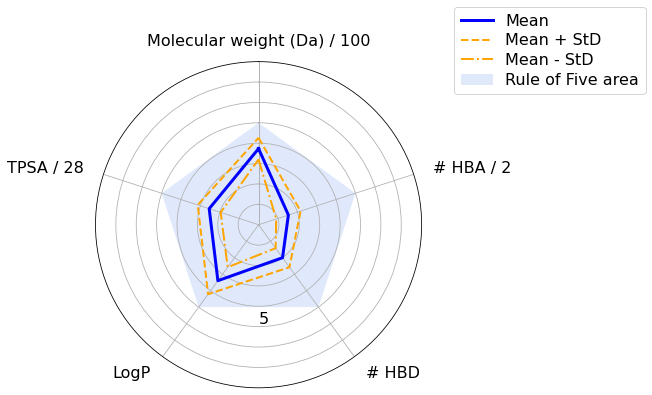

In [32]:
plot_radar(MolDB_ro5_true_stats, thresholds, scaled_threshold, properties_labels, y_max)

And for the Ro5-violating ones:

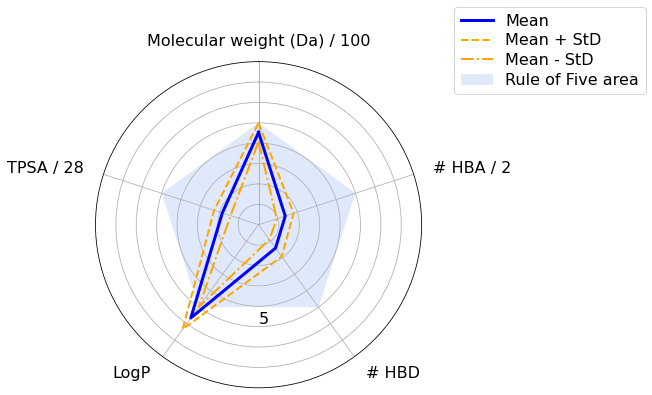

In [33]:
plot_radar(MolDB_ro5_false_stats, thresholds, scaled_threshold, properties_labels, y_max)

The blue square shows the area where a molecule's physicochemical properties are compliant with the Ro5. The blue line highlights the mean values, while the orange dashed lines show the standard deviations. We see that compounds mostly violate the Ro5 because of their logP values and their molecular weight.

Finally, we can plot some instagrams to better understand the distribution of values in our accepted molecules:

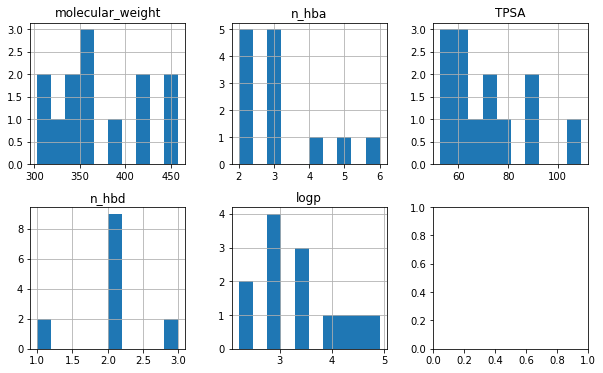

In [13]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)
MoleculeDatabase_ro5_fulfilled.hist(["molecular_weight"], ax=axes[0, 0])
MoleculeDatabase_ro5_fulfilled.hist(["n_hba"], ax=axes[0, 1])
MoleculeDatabase_ro5_fulfilled.hist(["n_hbd"], ax=axes[1, 0])
MoleculeDatabase_ro5_fulfilled.hist(["logp"], ax=axes[1, 1])
MoleculeDatabase_ro5_fulfilled.hist(["TPSA"], ax=axes[0, 2])
fig;

And, we save the filtered data:

In [14]:
MoleculeDatabase_ro5_fulfilled.to_csv("MolDB_Ro5.csv")